In [1]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt','r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s : i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i : s for s, i in stoi.items()}
vocab_size = len(itos)

In [3]:
# context length, how many chars do we take to predict the next char:
block_size = 7
vocab_size = 27

# build the dataset:
def build_dataset(words):
    X, Y = [], []

    for w in words:

        context = [0] * block_size
        for ch in w + '.': # there is no need for '.' + w + '.'
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # update
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1: n2])
Xte, Yte = build_dataset(words[n2:])

In [4]:
# lets build a deeper network:

class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        # self.out instead of "out"
        self.out = x @ self.weight

        if self.bias is not None:
            self.out += self.bias

        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1D:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters:
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers:
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass:
        if self.training:
            x_mean = x.mean(0, keepdim=True) # batch mean
            x_var = x.var(0, keepdim=True) # batch variance
        else:
            x_mean = self.running_mean
            x_var = self.running_var

        # normalize to unite variance:
        x_hat = (x - x_mean) / torch.sqrt(x_var + self.eps)
        self.out = self.gamma * x_hat + self.beta

        # update the buffers:
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var
        
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

n_embd = 10
n_hidden = 100

C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd * block_size,  n_hidden), Tanh(),
    Linear(n_hidden, n_hidden,bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden,bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden,bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden,bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size,bias=False), BatchNorm1D(vocab_size),
]

with torch.no_grad():
    # make the last layer less confident:
    #layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    # apply gain to all other layers:
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5 / 3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
# total number of parameters:
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

50924


In [5]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    # construct mini-batch:
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass:
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass:

    for layer in layers:
        layer.out.retain_grad()
    
    for p in parameters:
        p.grad = None

    loss.backward()

    # update:
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d} : {loss.item():.4f}')
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i == 1000:
        break

      0/ 200000 : 3.3064


layer  1 (      Tanh): mean   +0.05, std   0.75, saturated: 21.00%
layer  4 (      Tanh): mean   +0.00, std   0.64, saturated:  3.09%
layer  7 (      Tanh): mean   -0.00, std   0.65, saturated:  2.25%
layer 10 (      Tanh): mean   -0.00, std   0.65, saturated:  2.19%
layer 13 (      Tanh): mean   +0.01, std   0.65, saturated:  2.12%


Text(0.5, 1.0, 'activation distribution')

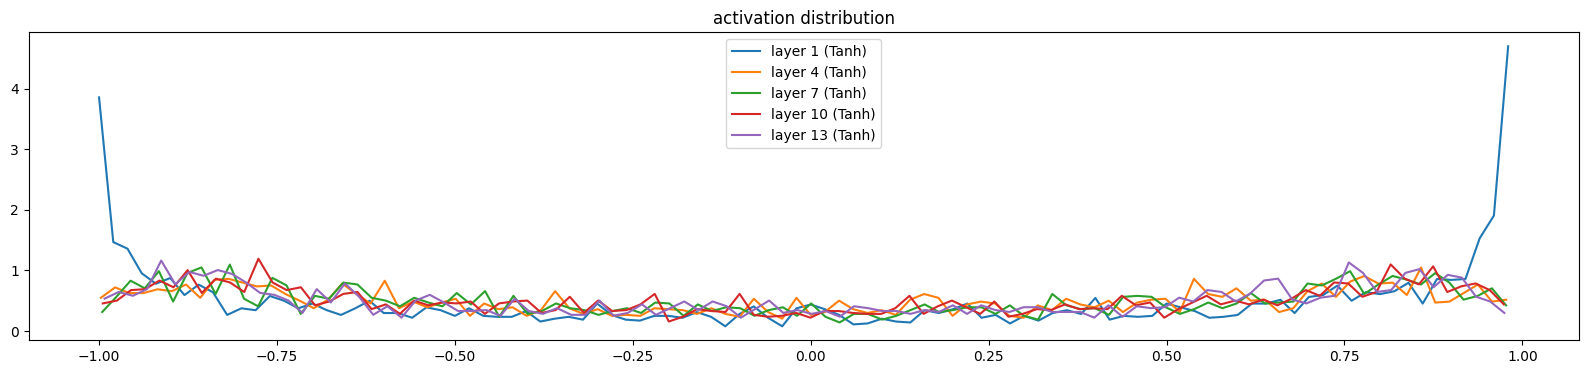

In [6]:
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]): # exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i:2d} ({layer.__class__.__name__:>10}): '
        f'mean {t.mean():+7.2f}, std {t.std():6.2f}, '
        f'saturated: {(t.abs() > 0.97).float().mean()*100:5.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.000000, std 3.289527e-03
layer 4 (      Tanh): mean -0.000000, std 2.953020e-03
layer 7 (      Tanh): mean +0.000000, std 2.626712e-03
layer 10 (      Tanh): mean +0.000000, std 2.305518e-03
layer 13 (      Tanh): mean +0.000000, std 2.350343e-03


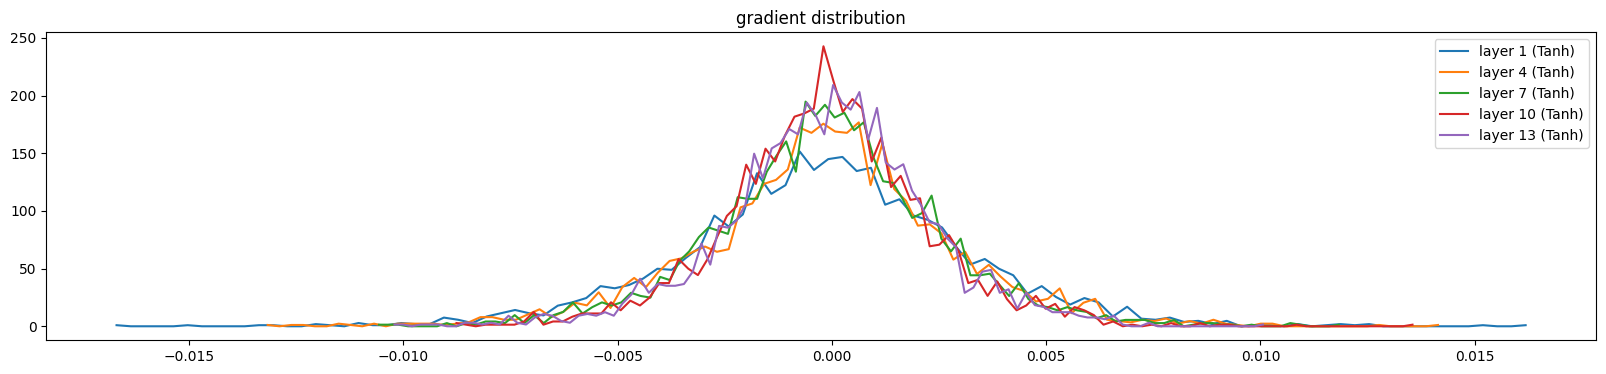

In [7]:
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % 
              (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends)
plt.title('gradient distribution')
plt.show()

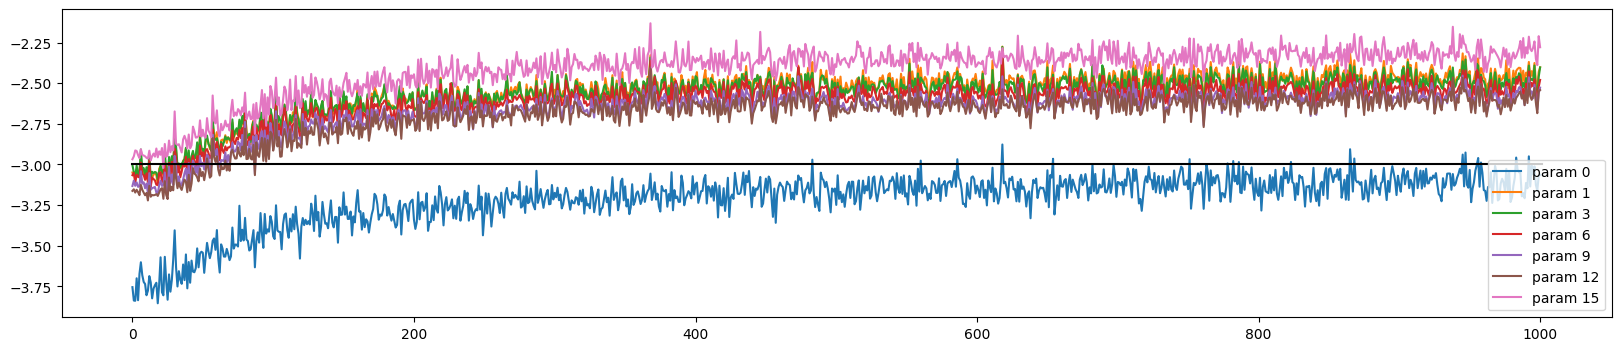

In [8]:
plt.figure(figsize=(20, 4))
legends = []

for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3
plt.legend(legends);

if it's below -3, that means that the parameters are not training fast enough.